Quantum Convolutional Neural Network for Classical Data Classification

The following code executes steps in order to showcase the working of a Quantum CNN. These steps include the following processes -

Data Pre Processing
Model Initialization
Creating Cost Function
Actual Training
STEP 1 - Data Pre Processing

For the sake of this experiment we are training our model on the Fashion MNIST Dataset which is an open source dataset of images of different clothing and wearing items. MNIST has a dataset of 10 categories of images. We are filtering the dataset to have only 2 categories to perform binary classification using the QCNN.

In [48]:
import numpy as np
from scipy.io.wavfile import write

# Parameters
sampling_rate = 44100  # Hz

# Generate Indian Classical Song
def generate_indian_classical_song():
    duration = 2  # seconds for each note
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Frequencies for a basic Indian raaga (Sa, Re, Ga, Ma, Pa, Dha, Ni, Sa')
    frequencies = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25]  # in Hz
    song = np.concatenate([0.5 * np.sin(2 * np.pi * f * t) for f in frequencies])

    return song

# Generate Western Pop Song
def generate_western_pop_song():
    duration = 1  # seconds for each chord
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Frequencies for chords (C major, G major, A minor, F major)
    chords = [
        [261.63, 329.63, 392.00],  # C major
        [196.00, 246.94, 392.00],  # G major
        [220.00, 261.63, 329.63],  # A minor
        [174.61, 220.00, 349.23],  # F major
    ]
    song = np.concatenate([
        0.5 * np.sum([np.sin(2 * np.pi * f * t) for f in chord], axis=0) for chord in chords
    ])

    # Add a simple beat
    beat = np.sin(2 * np.pi * 100 * t) * 0.1  # Low-frequency beat
    song += np.tile(beat, len(chords))

    return song

# Generate audio data
indian_classical_data = generate_indian_classical_song()
western_pop_data = generate_western_pop_song()

# Save the generated audio files
write("indian_classical.wav", sampling_rate, (indian_classical_data * 32767).astype(np.int16))
write("western_pop.wav", sampling_rate, (western_pop_data * 32767).astype(np.int16))

print("Generated 'indian_classical.wav' and 'western_pop.wav'")


Generated 'indian_classical.wav' and 'western_pop.wav'


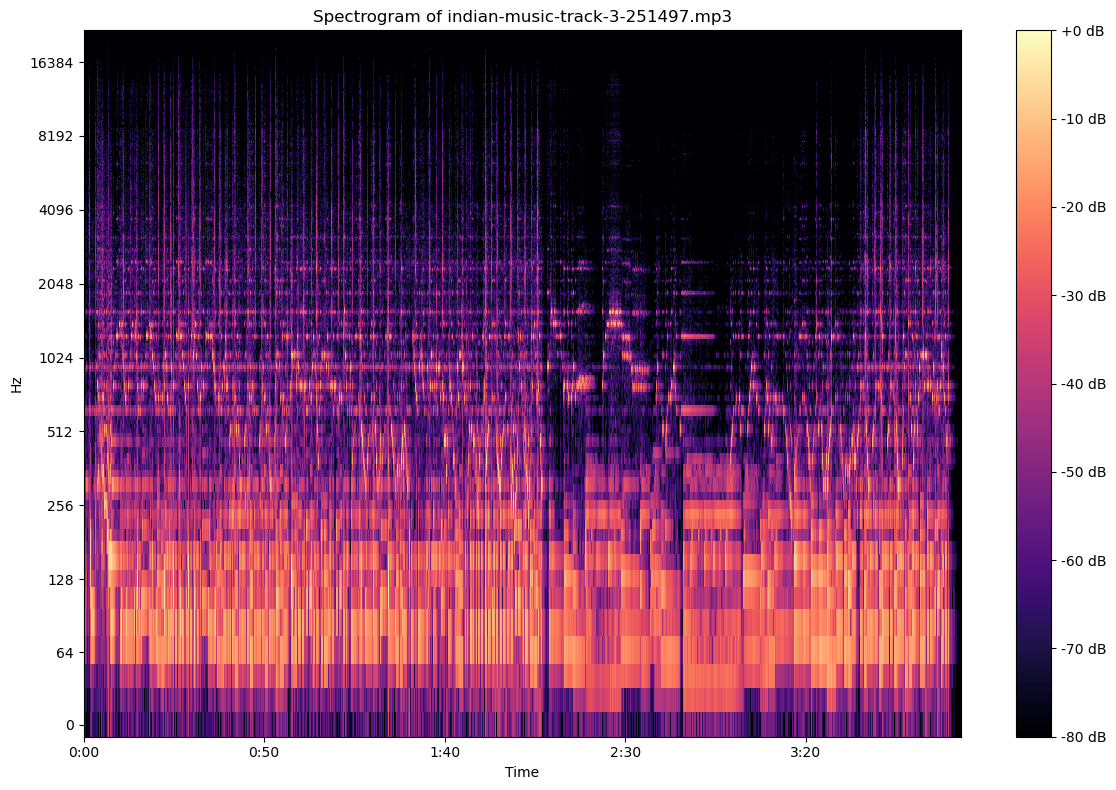

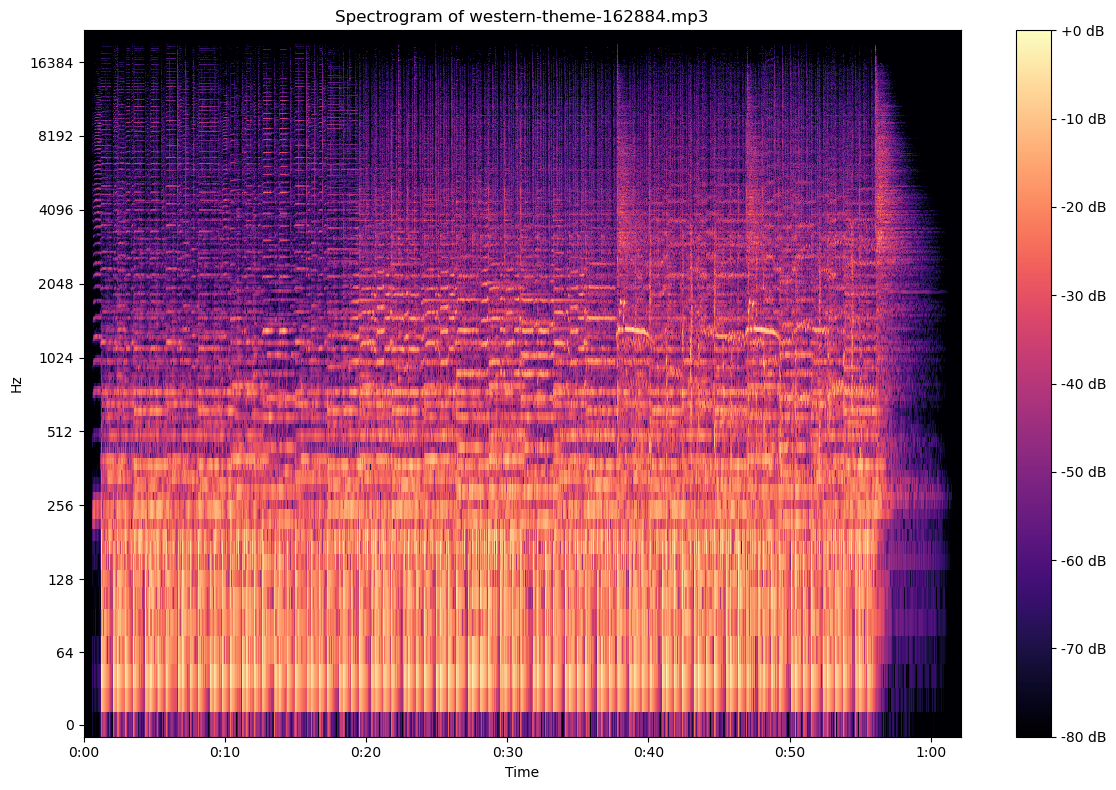

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Function to plot the spectrogram for a given audio file
def plot_spectrogram(audio_file):
    try:
        # Load the audio file (librosa supports MP3 files)
        y, sr = librosa.load(audio_file, sr=None)  # Preserve the original sampling rate

        # Compute the spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

        # Display the spectrogram
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram of {audio_file}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

# List of MP3 files to process
audio_files = ["indian-music-track-3-251497.mp3", "western-theme-162884.mp3"]

# Generate spectrogram for each file
for audio_file in audio_files:
    plot_spectrogram(audio_file)


In [50]:
def data_load_and_process(audio_files=None, labels=None, num_features=256, test_split=0.2):
    """
    Load audio files, generate spectrograms, and prepare data for the QCNN model.

    Args:
        audio_files (list): List of audio file paths.
        labels (list): Corresponding labels for the audio files.
        num_features (int): Number of features to match the embedding requirements (e.g., 256 for 8 qubits).
        test_split (float): Proportion of data to use for testing.

    Returns:
        tuple: X_train, X_test, Y_train, Y_test
    """
    if audio_files is None:
        audio_files = ["indian-music-track-3-251497.mp3", "western-theme-162884.mp3"]
    if labels is None:
        labels = [0, 1]  # Example binary labels

    spectrograms = []
    for file in audio_files:
        try:
            # Load the audio file
            y, sr = librosa.load(file, sr=None)

            # Generate spectrogram
            D = librosa.stft(y)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            # Flatten spectrogram and truncate/pad to `num_features`
            S_flattened = S_db.flatten()
            if len(S_flattened) >= num_features:
                S_resized = S_flattened[:num_features]  # Truncate
            else:
                S_resized = np.pad(S_flattened, (0, num_features - len(S_flattened)), mode='constant')  # Pad

            # Normalize to unit norm
            S_normalized = S_resized / np.linalg.norm(S_resized)

            spectrograms.append(S_normalized)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

    # Convert lists to arrays
    X = np.array(spectrograms)
    Y = np.array(labels)

    # Split into training and testing datasets
    split_index = int(len(X) * (1 - test_split))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    return X_train, X_test, Y_train, Y_test


STEP 2 - Model Initialization

In [51]:
# This module contains the set of unitary ansatze that will be used to benchmark the performances of Quantum Convolutional Neural Network (QCNN) in QCNN.ipynb module
import pennylane as qml

# Unitary Ansatze for Convolutional Layer
def U_TTN(params, wires):  # 2 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_5(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

# Pooling Layer

def Pooling_ansatz1(params, wires): #2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

def Pooling_ansatz2(wires): #0 params
    qml.CRZ(wires=[wires[0], wires[1]])

def Pooling_ansatz3(*params, wires): #3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

Next we define networks for convolutional neural networks and pooling layers and build the whole QCNN circuit with and without the pooling layers. We also use Amplitude Embedding to encode the data into the qubits.



In [52]:
import pennylane as qml
from pennylane.templates.embeddings import AmplitudeEmbedding

# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])

def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])

def conv_layer3(U, params):
    U(params, wires=[0,4])

# Quantum Circuits for Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])

def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])

def pooling_layer3(V, params):
    V(params, wires=[0,4])

def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 3 * U_params + 2]
    param5 = params[3 * U_params + 2: 3 * U_params + 4]
    param6 = params[3 * U_params + 4: 3 * U_params + 6]

    # Pooling Ansatz1 is used by default
    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param4)
    conv_layer2(U, param2)
    pooling_layer2(Pooling_ansatz1, param5)
    conv_layer3(U, param3)
    pooling_layer3(Pooling_ansatz1, param6)


def QCNN_structure_without_pooling(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]

    conv_layer1(U, param1)
    conv_layer2(U, param2)
    conv_layer3(U, param3)

def QCNN_1D_circuit(U, params, U_params):
    param1 = params[0: U_params]
    param2 = params[U_params: 2*U_params]
    param3 = params[2*U_params: 3*U_params]

    for i in range(0, 8, 2):
        U(param1, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(param1, wires=[i, i + 1])

    U(param2, wires=[2,3])
    U(param2, wires=[4,5])
    U(param3, wires=[3,4])



dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev)
def QCNN(X, params, U, U_params, cost_fn='cross_entropy'):


    # Data Embedding - Consider Amplitude Embedding
    AmplitudeEmbedding(X, wires=range(8), normalize=True)

    # Quantum Convolutional Neural Network
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)
    elif U == 'U_SU4_no_pooling':
        QCNN_structure_without_pooling(U_SU4, params, U_params)
    elif U == 'U_SU4_1D':
        QCNN_1D_circuit(U_SU4, params, U_params)
    elif U == 'U_9_1D':
        QCNN_1D_circuit(U_9, params, U_params)
    else:
        print("Invalid Unitary Ansatze")
        return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(4))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=4)
    return result

STEP 3 - Creating Cost Function

We define the Mean Square Loss and Cross Entropy Loss functions. We also define the circuit training function with the required hyper parameters.

In [53]:
# Implementation of Quantum circuit training procedure
from pennylane import numpy as pnp
import autograd.numpy as anp

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy
    return -1 * loss

def cost(params, X, Y, U, U_params, cost_fn):
    predictions = [QCNN(x, params, U, U_params, cost_fn=cost_fn) for x in X]

    if cost_fn == 'mse':
        loss = square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        loss = cross_entropy(Y, predictions)
    return loss

# Circuit training parameters
steps = 200
learning_rate = 0.01
batch_size = 25
def circuit_training(X_train, Y_train, U, U_params, cost_fn):
    if U == 'U_SU4_no_pooling' or U == 'U_SU4_1D' or U == 'U_9_1D':
        total_params = U_params * 3
    else:
        total_params = U_params * 3 + 2 * 3

    params = pnp.random.randn(total_params, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []

    for it in range(steps):
        batch_index = pnp.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, cost_fn),
                                                     params)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, params

In [54]:
import numpy as np

def accuracy_test(predictions, labels, cost_fn):
    if cost_fn == 'mse':
        acc = 0
        for l, p in zip(labels, predictions):
            if np.abs(l - p) < 0.5:
                acc = acc + 1
        return acc / len(labels)

    elif cost_fn == 'cross_entropy':
        acc = 0
        for l,p in zip(labels, predictions):
            if p[0] > p[1]:
                P = 0
            else:
                P = 1
            if P == l:
                acc = acc + 1
        return acc / len(labels)

def Benchmarking(Unitaries, U_num_params, cost_fn):
    I = len(Unitaries)

    for i in range(I):
        U = Unitaries[i]
        U_params = U_num_params[i]
        Encoding = 'resize_256'
        Embedding = 'Amplitude'

        X_train, X_test, Y_train, Y_test = data_load_and_process()

        print("\n")
        print("Loss History for QCNN circuits, " + U + " " + Encoding + " with " + cost_fn)
        loss_history, trained_params = circuit_training(X_train, Y_train, U, U_params, cost_fn)

        predictions = [QCNN(x, trained_params, U, U_params, cost_fn) for x in X_test]

        accuracy = accuracy_test(predictions, Y_test, cost_fn)
        print("Accuracy for " + U + " " + Encoding + " :" + str(accuracy))

        print("Loss History for QCNN circuits, " + U + " " + Encoding + " with " + cost_fn)
        print(str(loss_history))
        print("Accuracy for " + U + " " + Encoding + " :" + str(accuracy))
        print("")

STEP 4 - Actual Training

Finally we run the model for a QCNN circuit for 4 different unitary parametrized gates with the cross entropy loss function and check their respective results.

In [55]:
# This generates the results of the benchmarking code

"""
Here are possible combinations of benchmarking user could try.
Unitaries: ['U_TTN', 'U_5', 'U_6', 'U_9', 'U_13', 'U_14', 'U_15', 'U_SO4', 'U_SU4', 'U_SU4_no_pooling', 'U_SU4_1D', 'U_9_1D']
U_num_params: [2, 10, 10, 2, 6, 6, 4, 6, 15, 15, 15, 2]
Encodings: ['resize256']
dataset: 'fashion_mnist'
cost_fn: 'mse' or 'cross_entropy'
"""

Unitaries = ['U_SU4', 'U_SU4_1D', 'U_SU4_no_pooling', 'U_9_1D']
U_num_params = [15, 15, 15, 2]
Encodings = ['resize256']
cost_fn = 'cross_entropy'

Benchmarking(Unitaries, U_num_params, cost_fn=cost_fn)



Loss History for QCNN circuits, U_SU4 resize_256 with cross_entropy


/opt/homebrew/anaconda3/envs/tfq_env/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  15.456961782280388
iteration:  10  cost:  3.5255628017246163
iteration:  20  cost:  0.7397563656564103
iteration:  30  cost:  0.21581920770786664
iteration:  40  cost:  0.21372092570450513
iteration:  50  cost:  2.6320846058797223
iteration:  60  cost:  0.5758212976157595
iteration:  70  cost:  0.17264325537144373
iteration:  80  cost:  0.17818222793446867
iteration:  90  cost:  3.9146776676133004
iteration:  100  cost:  0.21312699835178003
iteration:  110  cost:  0.16069929765397806
iteration:  120  cost:  0.15193467841704464
iteration:  130  cost:  0.1479292839494853
iteration:  140  cost:  0.14575394393760857
iteration:  150  cost:  0.14378037957999715
iteration:  160  cost:  0.14223931868202708
iteration:  170  cost:  0.14094095019672878
iteration:  180  cost:  0.1398081360507157
iteration:  190  cost:  0.1387756483555498
Accuracy for U_SU4 resize_256 :0.0
Loss History for QCNN circuits, U_SU4 resize_256 with cross_entropy
[15.456961782280388, 11.4369328632798